<a href="https://colab.research.google.com/github/Amit-GH/NewsDataExploration/blob/mainline/News_Title_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis on News Titles dataset

Note:
* In our analysis we read through the data multiple times. In a production setting this is not efficient and can be improved. Many steps can be performed at once like finding vocabulary size and creating in-memory index. But we keep it separate to make the analysis easier to understand and show the natural progress done in the work.

## Infrastructure and library setup

In [1]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import scipy
import os
import pickle

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/Eluvio\ Dataset

/content/drive/MyDrive/Eluvio Dataset


In [4]:
path = pathlib.Path().absolute()
print(path)

/content/drive/MyDrive/Eluvio Dataset


In [5]:
assert str(path) == '/content/drive/MyDrive/Eluvio Dataset' or str(path) == '/content/drive/My Drive/Eluvio Dataset'

In [6]:
'''
Look at few rows of the data to understand the data types, rows and columns.
Create a high level sense of the data to pose questions later on.
'''

filename = 'Eluvio_DS_Challenge.csv'

# print partial data and all column names.
for chunk in pd.read_csv(filename, sep=',', header=0, chunksize=5):
    print(chunk)
    print(chunk.columns)
    break

   time_created date_created  up_votes  ...  over_18    author   category
0    1201232046   2008-01-25         3  ...    False     polar  worldnews
1    1201232075   2008-01-25         2  ...    False     polar  worldnews
2    1201232523   2008-01-25         3  ...    False     polar  worldnews
3    1201233290   2008-01-25         1  ...    False   fadi420  worldnews
4    1201274720   2008-01-25         4  ...    False  mhermans  worldnews

[5 rows x 8 columns]
Index(['time_created', 'date_created', 'up_votes', 'down_votes', 'title',
       'over_18', 'author', 'category'],
      dtype='object')


## Identify relevant and irrelevant fields.

Not all fields are relevant. If a particular field has only cardinality=1, then it is unhelpful for most types of analysis (if any).

In [7]:
categories = set()
author_stats = {} # key = author name, value = [count, upvotes, downvotes]
downvotes_set = set()
max_upvotes = 0

# Read the file in paginated way as it can be big.
for chunk in pd.read_csv(filename, sep=',', header=0, chunksize=100000):
    categories.update(chunk['category'])

    for author, upvotes, downvotes in zip(chunk['author'], chunk['up_votes'], chunk['down_votes']):
        author_stats[author] = author_stats.get(author, np.zeros((3, ))) + np.array([1, upvotes, downvotes])
        max_upvotes = max(max_upvotes, upvotes)
    downvotes_set.update(chunk['down_votes'])

In [8]:
print('Unique type of downvotes = {}'.format(len(downvotes_set)))
print('categories: size = {}, content = {}\n'.format(len(categories), categories))
print('\nBased on data, categories and content columns don\'t help at all as there is no variability.')

Unique type of downvotes = 1
categories: size = 1, content = {'worldnews'}


Based on data, categories and content columns don't help at all as there is no variability.


## Authors statistics and quality
We pose three questions and try to answer them from the data.
1. Who are authors that have written the most number of news articles?
1. Who are the authors that write very popular articles? We can use upvotes data to answer this question.
1. Which authors write quality articles that are most likely to be upvoted by people?

In [9]:
print('unique authors = {}\n'.format(len(author_stats)))
author_stats_list = list(author_stats.items())

# sort authors by their count
author_stats_list.sort(key=lambda a:a[1][0], reverse=True)
print('Top 10 authors by counts are:')
for i, (author, stat) in enumerate(author_stats_list[:10]):
    print('  {} -> {} : {}'.format(i+1, author, stat[0]))

# sort authors by upvotes
author_stats_list.sort(key=lambda a:a[1][1], reverse=True)
print('\nTop 10 authors by upvotes are:')
for i, (author, stat) in enumerate(author_stats_list[:10]):
    print('  {} -> {} : {}'.format(i+1, author, stat[1]))

# sort authors by upvotes per count
author_stats_list.sort(key=lambda a:a[1][1]/a[1][0], reverse=True)
print('\nTop 10 authors by upvotes per count are:')
for i, (author, stat) in enumerate(author_stats_list[:10]):
    print('  {} -> {} : {}'.format(i+1, author, stat[1]/stat[0]))

unique authors = 85838

Top 10 authors by counts are:
  1 -> davidreiss666 : 8897.0
  2 -> anutensil : 5730.0
  3 -> DoremusJessup : 5037.0
  4 -> maxwellhill : 4023.0
  5 -> igeldard : 4013.0
  6 -> readerseven : 3170.0
  7 -> twolf1 : 2923.0
  8 -> madam1 : 2658.0
  9 -> nimobo : 2564.0
  10 -> madazzahatter : 2503.0

Top 10 authors by upvotes are:
  1 -> maxwellhill : 1985416.0
  2 -> anutensil : 1531544.0
  3 -> Libertatea : 832102.0
  4 -> DoremusJessup : 584380.0
  5 -> Wagamaga : 580121.0
  6 -> NinjaDiscoJesus : 492582.0
  7 -> madazzahatter : 428966.0
  8 -> madam1 : 390541.0
  9 -> davidreiss666 : 338306.0
  10 -> kulkke : 333311.0

Top 10 authors by upvotes per count are:
  1 -> navysealassulter : 12333.0
  2 -> seapiglet : 11288.0
  3 -> DawgsOnTopUGA : 10515.0
  4 -> Flamo_the_Idiot_Boy : 10289.0
  5 -> haunted_cheesecake : 9408.0
  6 -> bendertheoffender22 : 8781.0
  7 -> crippledrejex : 8601.0
  8 -> FlandersNed : 8446.0
  9 -> lesseva96 : 8404.0
  10 -> sverdrupian : 82

## Data pre-processing
* We pre-process the `title` data which is a string of English language text.
* We find vocabulary size to get an idea about the diversity of text.

In [10]:
# Downloads the stop words data.
nltk.download('stopwords')

# Using the stopwords.
from nltk.corpus import stopwords

# Initialize the stopwords for English language.
stop_words = set(stopwords.words('english'))
print(len(stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
179


In [11]:
'''
Input: a string sentence (a news title in our case)
Returns:
    a list of words present in the sentence after pre-processing.
'''
def pre_process_sentence_to_list(sentence):
    # sent = re.sub(r'[^\w\s]', ' ', sentence)
    sentence = sentence.lower()
    sent = re.sub(r'[^\w ]', ' ', sentence)
    words = sent.split(' ')
    words_nostop = [word for word in words if word not in stop_words and len(word) > 1]
    return words_nostop

In [12]:
# Read all titles, prune the data and find number of unique words.
all_unique_words = set()

for chunk in pd.read_csv(filename, sep=',', header=0, chunksize=100000):
    for title in chunk['title']:
        words_list = pre_process_sentence_to_list(title)
        words_set = set(words_list)
        all_unique_words.update(words_set)

In [13]:
print('Vocabulary size: {}.'.format(len(all_unique_words)))
print('Printing random 10 words from the vocabulary:')
for i, word in enumerate(all_unique_words):
    print(word, )
    if i == 10:
        break

Vocabulary size: 87835.
Printing random 10 words from the vocabulary:
arab
польша
dirce
275
cfr
congresswoman
deathless
hawaii
waverider
baltics
généraux


## Inverted Index creation

In document ranking and processing tasks, an inverted index is a very helpful data structure. For large document collection it is saved on disk.
It maps every word on the collection to a posting list. The posting list can be of a variety of types. We create a count inverted index where the posting list for a word consists of a dictionary where key is title_id and value is the number of times the word appears in the title string.

`index = {word : {title_id : count}}`

In [14]:
'''
Create in-memory reverse index from the titles. Index can be saved on file if it is too big.
Here we skip that part and use in-memory index for our analysis.

Create some more helper data structures described below.

inMemoryIndex - the in-memory index data structure.
title_len - a dict where key is title_id and value is number of words in the title string.
avgtl - average title length across the dataset.
num_titles - Total number of titles or rows in the dataset.
'''

inMemoryIndex = {}
title_index = 0

title_len = {}
avgtl = 0
# total number of terms present in the collection including repetition.
sumtl = 0

for chunk in pd.read_csv(filename, sep=',', header=0, chunksize=50000):
    for i, title in enumerate(chunk['title']):
        title_id = title_index + i
        words_list = pre_process_sentence_to_list(title)
        
        title_len[title_id] = len(words_list)
        sumtl += len(words_list)

        for word in words_list:
            inMemoryIndex[word] = inMemoryIndex.get(word, {})
            title_id_to_count = inMemoryIndex[word]
            title_id_to_count[title_id] = title_id_to_count.get(title_id, 0)
            title_id_to_count[title_id] += 1
    title_index += chunk.shape[0]

num_titles = title_index

avgtl = sumtl / num_titles

## Find news titles that match the most for a word

Given a word, find the top $k$ news titles based on the number of occurence of that word in the title.

In [15]:
'''
Given a word, find at most k titles having the word most number of times.
Returns a list of title ids. Most matched titles are placed first.
'''
def give_matching_title_ids(word, k):
    title_id_count_list = list(inMemoryIndex.get(word, {}).items())
    title_id_count_list.sort(key=lambda a:a[1], reverse=True)
    title_id_list = []
    for tid_count in title_id_count_list[:k]:
        title_id_list.append(tid_count[0])
    return title_id_list

'''
Given a list of sorted title_ids, returns a list of title strings.
This is a private helper function for the generic method which allows non-sorted input.
'''
def _title_id_to_title(title_id_list):
    title_index = 0
    titles = []
    
    if len(title_id_list) == 0:
        return titles
    
    tid_index = 0
    done = False
    for chunk in pd.read_csv(filename, sep=',', header=0, chunksize=50000):
        for i, title in enumerate(chunk['title']):
            title_id = i + title_index
            if title_id == title_id_list[tid_index]:
                titles.append(title)
                tid_index += 1
                if tid_index == len(title_id_list):
                    done = True
                    break
        if done == True:
            break
        title_index += chunk.shape[0]
    return titles

'''
Given a list of title_ids (may not be sorted), returns a list of title strings.
'''
def title_id_to_title(title_id_list):
    if len(title_id_list) == 0:
        return []
    
    title_id_list = np.array(title_id_list)
    sorted_tids_index = np.argsort(title_id_list)
    matching_titles = _title_id_to_title(title_id_list[sorted_tids_index])
    pos_arr = np.zeros(len(title_id_list), dtype=np.int8)
    for pos, ind in enumerate(sorted_tids_index):
        pos_arr[ind] = pos
    ret_list = []
    for pos in pos_arr:
        ret_list.append(matching_titles[pos])
    return ret_list

In [16]:
'''
Given a word and k, prints the top k titles that have the word in them the most
number of times.
'''
def print_matching_titles(word, k):
    word = pre_process_sentence_to_list(word)[0]
    matching_tids = np.array(give_matching_title_ids(word, k))
    # print(matching_tids)
    matching_titles = title_id_to_title(matching_tids)
    print('Top {} titles for word \'{}\' based on frequency of occurence of the word.'.format(k, word))
    print('  Rank -> title_id : title string')
    for i, (tid, title) in enumerate(zip(matching_tids, matching_titles)):
        print('  {} -> {} : {}'.format(i+1, tid, title))

### Example

1. Find top titles for word 'Prison'
1. Find top titles for word 'turkish'.

In [17]:
print_matching_titles('Prison', 5)
print()
print_matching_titles('turkish', 5)

Top 5 titles for word 'prison' based on frequency of occurence of the word.
  Rank -> title_id : title string
  1 -> 48641 : How my father went from the prison of the shah to the prison of Khamenei. Right now, he is in solitary confinement in Evin prison in Tehran
  2 -> 108093 : France sends ex-dictator Noriega to prison in native Panama - After more than 20 years in prison and being passed from country to country, former Panamanian strongman Manuel Noriega has returned home to serve out prison sentences for crimes committed during his dictatorship.
  3 -> 188209 : 9 Escaped, 2 Guards Killed in Mexico Prison Attack. The attackers opened fire on prison guard towers early on Sunday before entering the prison’s territory and releasing several prisoners.
  4 -> 232103 : Islamist women and girls receive heavy prison sentences for Egypt protests  ...Among them were seven girls ages 15 and 16, who were sentenced to prison terms until they turn 18. The rest — most ages 18 to 22 — were sentenc

## Zipf distribution verification

In a document or collection of documents, the distribution of frequencies of different words roughly follow a pattern. This distribution is described by the *Zipf's Law* which states that the rank of a word ($r$) is inversely proportional to this frequency ($f$). i.e. $r \propto \frac{1}{f}$. Alternatively, the rank of a word times its frequency is a constant ($k$). 

$$r . f = k$$

Another way to state the Zipf's Law is to use the probability of terms instead of frequency. For that we need to divide frequency by the total number of terms in the document(s). We get,

$$r. P_r = c$$

where, $P_r$ is the probability of the word having rank $r$, and $c$ is a new contant which is essentially the constant $k$ divided by the total number of words.

Taking $\log$ on both sides, 

$$\log r + \log P_r = \log c$$

We show the existence of this distribution by plotting a graph between $\log r$ (the log of the word rank) and $\log P_r$ (the log of the probability of a word) for all words.

In [18]:
'''
We can find if the words in the titles follow zipf distribution.
rank * term probability should almost be equal for all words. We will investigate
top k words.

Input:
    k - number of top-k words we want to know.
    index - the in-memory count index.
Returns:
    terms - list of k terms.
    term_probs - prob of each term in descending order.
    r_term_probs - rank * term_prob for every term.
'''

from queue import PriorityQueue

def zipf(k, index):
    total_term_count = 0
    q = PriorityQueue()

    for term in index:
        tid_count_list = list(index[term].items())
        term_count = 0
        for tid, count in tid_count_list:
            term_count += count
        total_term_count += term_count

        q.put((term_count, term))
        if q.qsize() > k:
            q.get()
    
    terms = []
    term_probs = []
    while not q.empty():
        term_count, term = q.get()
        terms.append(term)
        term_probs.append(term_count / total_term_count)
    terms.reverse()
    term_probs.reverse()

    r_term_probs = []
    for r, tp in enumerate(term_probs):
        r_term_probs.append((r + 1) * tp)
    
    return terms, term_probs, r_term_probs

In [19]:
terms, term_probs, r_term_probs = zipf(10, inMemoryIndex)
print(terms)
print(r_term_probs)

['china', 'says', 'us', 'new', 'syria', 'russia', 'world', 'police', 'government', 'israel']
[0.005093094599548515, 0.00981381080090297, 0.014423199367149664, 0.018050126377124776, 0.018351694997009397, 0.021724517162206487, 0.02443361824461209, 0.025706071890254492, 0.02831329950413861, 0.030963360280923807]


No handles with labels found to put in legend.


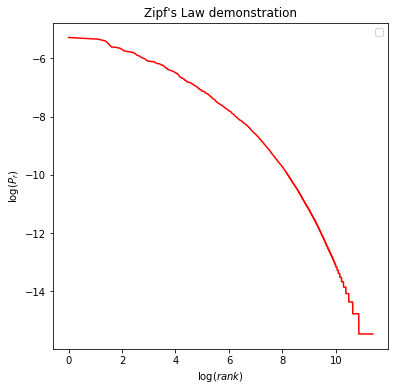

In [20]:
max_rank = len(inMemoryIndex)
terms, term_probs, r_term_probs = zipf(len(inMemoryIndex), inMemoryIndex)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(
    np.log(np.arange(max_rank) + 1),
    np.log(term_probs[:max_rank]),
    color='red',
    label=''
)
ax.legend()
ax.set(
    xlabel=r'$\log(rank)$',
    ylabel=r'$\log(P_r)$',
    title="Zipf's Law demonstration",
)
plt.show()

## Most popular news titles
 

In [21]:
'''
Returns a list of tuple where each entry is (upvotes, author, title) and sorted
by the number of upvotes.
'''
def most_upvoted_title(k):
    q = PriorityQueue()
    for chunk in pd.read_csv(filename, sep=',', header=0, chunksize=50000):
        for upvotes, author, title in zip(chunk['up_votes'], chunk['author'], chunk['title']):
            q.put((upvotes, author, title))
            if q.qsize() > k:
                q.get()
    
    ret_list = []
    while not q.empty():
        (upvotes, author, title) = q.get()
        ret_list.append((upvotes, author, title))
    ret_list.reverse()

    return ret_list

In [22]:
print('List of most upvoted news titles along with upvotes and respective author.')
print('  rank -> author : upvotes : title string')
for i, (upvotes, author, title) in enumerate(most_upvoted_title(10)):
    print(' {} -> {} : {} : {}'.format(i+1, author, upvotes, title))

List of most upvoted news titles along with upvotes and respective author.
  rank -> author : upvotes : title string
 1 -> KRISHNA53 : 21253 : A biotech startup has managed to 3-D print fake rhino horns that carry the same genetic fingerprint as the actual horn. The company plans to flood Chinese rhino horn market at one-eighth of the price of the original, undercutting the price poachers can get and forcing them out eventually.
 2 -> joeyoungblood : 13435 : Twitter has forced 30 websites that archive politician s deleted tweets to shut down, removing an effective tool to keep politicians honest
 3 -> mister_geaux : 13244 : 2.6 terabyte leak of Panamanian shell company data reveals  how a global industry led by major banks, legal firms, and asset management companies secretly manages the estates of politicians, Fifa officials, fraudsters and drug smugglers, celebrities and professional athletes. 
 4 -> navysealassulter : 12333 : The police officer who leaked the footage of the surfers 

## BM25 model for document ranking

BM25 is a popular non-binary probabilistic document ranking model. It takes in a query string and returns a ranked list of documents that match the most for the input query. There were many earlier version of the BM model. We use the final version which has shown the best performance over a variety of document ranking tasks.

To make the below code understandable, we mention the formula for completeness.
$$score(q,p) = \sum_{w \in {q \cap p}} \frac{(k_1+1) count(w,p)}{k_1(1-b+b(\frac{|p|}{avgdl})) + count(w,p)} ln\frac{|C|-df(w)+0.5}{df(w)+0.5}$$


$score(q,p)$ - score assigned to a passage $p$ for a query $q$

$count(w,p)$ - number of times term $w$ occurs in passage $p$ 

$b$ - set this to 0.75 (can be tuned based on the task)

$|p|$ - Number of terms in passage $p$

$avgdl$ - Average number of terms in passages in collection

$|C|$ - number of passages in collection $C$

$df(w)$ - number of passages containing term $w$

$k_1$ - set to 1.2 (can be fine-tuned)

In [23]:
'''
Create a document frequency dict where key is word and value is the number of titles
containing that word.
Input:
    index - in-memory index.
Returns:
    title_freq - a document frequency dict where key is word and value is the number of titles
        containing that word.
'''
def create_title_freq(index):
    title_freq = {}
    for word in index:
        title_freq[word] = len(index[word])
    return title_freq

title_freq = create_title_freq(inMemoryIndex)

In [24]:
'''
Given a query (a sentence/title), we will find the top k matching titles.

Input:
    query - a sentence string.
    index - in-memory count index.
    num_titles - total number of titles in the dataset.
    title_len - a dict where key is title_id and value is number of words in the title string.
    k - number of matching titles to find.
Returns:
    ranking_bm25 - A list of (bm25_score, title_id, time_created, up_votes) tuples.
'''
def bm25(query, index, num_titles, title_len, k):
    # A list of (bm25_score, title_id, time_created, up_votes) tuples.
    ranking_bm25 = []
    
    title_index = 0
    pq = PriorityQueue()
    for chunk in pd.read_csv(filename, sep=',', header=0, chunksize=100000):
        for i, (title, time_c, up_votes) in enumerate(zip(chunk['title'], chunk['time_created'], chunk['up_votes'])):
            title_id = i + title_index
            score = bm25_score(query, title, num_titles, index, avgtl)
            pq.put((score, title_id, time_c, up_votes))
            if pq.qsize() > k:
                pq.get()
        title_index += chunk.shape[0]

    score_tid_list = []
    while not pq.empty():
        score_tid_list.append(pq.get())
    score_tid_list.reverse()

    return score_tid_list

def bm25_score(query, title, num_titles, index, avgtl):
    q_words = pre_process_sentence_to_list(query)
    t_words = pre_process_sentence_to_list(title)
    common_words = set(q_words).intersection(set(t_words))

    if len(common_words) == 0:
        return -np.inf
    
    t_words_count = {}
    for word in t_words:
        t_words_count[word] = t_words_count.get(word, 0) + 1
    
    score = 0
    k1 = 1.2 # hyperparameter
    b = 0.75 # hyperparameter
    for word in common_words:
        n1 = (k1 + 1) * t_words_count.get(word, 0)
        if n1 == 0:
            continue
        
        d1 = k1 * (1 - b + b * (len(t_words)/avgtl)) + t_words_count.get(word, 0)
        n2 = num_titles - title_freq[word] + 0.5
        d2 = title_freq[word] + 0.5

        score += (n1 / d1) * np.log(n2 / d2)
    return score

### Examples for BM25 ranking

Given a query string, we find the top $k$ most relevant titles. Use-cases:
1. The query is set to an existing `title` and we wish to find other news titles that match with this one. 
1. The query can be any user given string (search term) and we find the most relevant new titles for that user. 

In [25]:
def print_top_titles_bm25(query, k):
    score_tid_list = bm25(query, inMemoryIndex, num_titles, title_len, k)
    title_id_list = [tid for score, tid, _, _ in score_tid_list]
    titles = title_id_to_title(title_id_list)

    print('Matching titles for query \'{}\' are:'.format(query))
    print('  rank -> title_id : title string')
    for i, title in enumerate(titles):
        print('  {} -> {} : {}'.format(i + 1, title_id_list[i], title))

In [26]:
test_query = 'EU Commission declines comment on Microsoft-Yahoo' # This is an existing title.
print_top_titles_bm25(test_query, 10)

Matching titles for query 'EU Commission declines comment on Microsoft-Yahoo' are:
  rank -> title_id : title string
  1 -> 28 : EU Commission declines comment on Microsoft-Yahoo
  2 -> 5915 : Russia declines to comment on U.S. military attache expulsions
  3 -> 20153 : Google Laughs at Yahoo! and Microsoft 
  4 -> 6851 : Microsoft Wants A Deal With Yahoo, Again!
  5 -> 5898 : The Yahoo – Microsoft drama is going to make a Better Yahoo
  6 -> 353317 : Kremlin declines to comment on report on Putin s absence from Moscow
  7 -> 5459 : Microsoft-Yahoo Bid, Sequence of Events
  8 -> 395489 : Kremlin declines comment on question of Russian troops inside Syria
  9 -> 347184 : NSA chief declines comment on spyware reports, says program are lawful
  10 -> 2288 : Why Microsoft s MSN is bending to China s wishes on Tibet: China could block Microsoft s acquisition of Yahoo.


In [27]:
# This is also an existing title so we expect the same title to be the most matched one
# followed by other relevant titles.
test_query = 'Mass Evacuations Continue  in Kenya'
print_top_titles_bm25(test_query, 5)

Matching titles for query 'Mass Evacuations Continue  in Kenya' are:
  rank -> title_id : title string
  1 -> 16 : Mass Evacuations Continue  in Kenya
  2 -> 454190 : Mass evacuations after Japan quake
  3 -> 358600 : Yemen conflict: Evacuations continue as fighting intensifies
  4 -> 357822 : Fire in London has caused mass evacuations of buildings
  5 -> 219986 : Major Cyclone Causes Mass Evacuations in India


In [28]:
test_query = 'Jihadi John Unmasked For The First Time In New Video'
print_top_titles_bm25(test_query, 5)

Matching titles for query 'Jihadi John Unmasked For The First Time In New Video' are:
  rank -> title_id : title string
  1 -> 391399 : Jihadi John Unmasked For The First Time In New Video
  2 -> 348600 :  Jihadi John  Unmasked: First Picture of Mohammed Emwazi as an Adult Emerges
  3 -> 348293 :  Jihadi John  killer from Islamic State beheading videos unmasked as Londoner
  4 -> 428051 :  New Jihadi John  appears in ISIL execution video
  5 -> 391357 : ISIL executioner  Jihadi John  filmed unmasked, vows to return to Britain to continue killings


In [29]:
# This is a random user string.
user_string = 'baseball match score between boston and seattle'
print_top_titles_bm25(user_string, 5)

Matching titles for query 'baseball match score between boston and seattle' are:
  rank -> title_id : title string
  1 -> 333141 : Inside the Mafia-Run World of Baseball Match-Fixing in Taiwan
  2 -> 29869 : Goodbye, Seattle P-I
  3 -> 30578 : World Baseball Classic
  4 -> 373227 : The Honduras U20 national soccer team is under investigation for match-fixing, after irregular betting patterns were noticed on a shock 3-0 loss to Fiji where they  didn t appear to want to score 
  5 -> 96185 : Baseball bats are selling out in the UK


## Improving BM25 Model by using time/recency information

Instead of just showing the top-k titles by matching score, the user might be interested in the most recent titles as these are news articles. We create a hybrid model where we first fetch a lot of documents (~10 times) using the BM25 model and then sort them based on time. We select a subset (one third) of those titles and then sort them based on popularity before showing the final (k) results.

More complicated schemes can be used and fine-tuned based on the dataset. 

We run the model on the same queries as above and can see the difference in results.

In [30]:
'''
We can use a better ranking model by combining BM25 with upvotes and time created information.
First we find 10*k relevant titles using the BM25 model. Then we sort them based on
time created and pick 3*k most recent titles. Then we sort them based on number of 
upvotes and pick top k which is the final result.
'''
def print_top_titles_bm25_recent(query, k):
    # Get 10*k models using BM25.
    score_tid_list = bm25(query, inMemoryIndex, num_titles, title_len, k*10)
    # sort based on time created
    score_tid_list.sort(key=lambda a:a[2], reverse=True)
    most_recent = score_tid_list[:3*k]
    # sort based on upvotes
    most_recent.sort(key=lambda a:a[3], reverse=True)
    most_upvoted = most_recent[:k]

    title_id_list = [tid for _, tid, _, _ in most_upvoted]
    # only use k titles
    titles = title_id_to_title(title_id_list)

    print('Matching recent titles for query \'{}\' are:'.format(query))
    print('  rank -> title_id : title string')
    for i, (tid, title) in enumerate(zip(title_id_list, titles)):
        print('  {} -> {} : {}'.format(i+1, tid, title))

In [31]:
test_query = 'EU Commission declines comment on Microsoft-Yahoo'
print_top_titles_bm25_recent(test_query, 10)

Matching recent titles for query 'EU Commission declines comment on Microsoft-Yahoo' are:
  rank -> title_id : title string
  1 -> 496048 : Watching pirate streams isn t illegal, EU Commission argues
  2 -> 475249 : India’s top court ordered Google, Yahoo, and Microsoft to ban ads for pre-birth gender tests
  3 -> 477378 : Diesel Emissions: EU Commission Has Known for Years about Manipluation
  4 -> 465772 : Facebook, Twitter, Microsoft and YouTube adopt EU hate speech rules
  5 -> 504793 : China slams EU Commissioner s  slitty eyes  comment
  6 -> 475106 : India s Supreme Court tells Google, Yahoo and Microsoft to stop hosting sex selection ads
  7 -> 506199 : Turkey  backsliding  in bid to join EU, says Commission
  8 -> 475393 : EU Commission Seeks Sanctions on Spain, Portugal Over Deficits
  9 -> 465435 : Facebook, Twitter, YouTube, Microsoft back EU hate speech rules
  10 -> 474313 : EU leaders on collision course with Commission over CETA


In [32]:
test_query = 'Mass Evacuations Continue  in Kenya'
print_top_titles_bm25_recent(test_query, 5)

Matching recent titles for query 'Mass Evacuations Continue  in Kenya' are:
  rank -> title_id : title string
  1 -> 380364 : Mass arrests in The Hague as clashes over death in police custody continue
  2 -> 389622 : Mass evacuations underway in Tianjin as fires reignite, causing further blasts
  3 -> 450354 : Evacuations after huge explosion in central Paris
  4 -> 357822 : Fire in London has caused mass evacuations of buildings
  5 -> 496170 : Mexico s erupting Colima volcano triggers evacuations


In [33]:
# This is a random user string.
user_string = 'baseball match score between boston and seattle'
print_top_titles_bm25_recent(user_string, 5)

Matching recent titles for query 'baseball match score between boston and seattle' are:
  rank -> title_id : title string
  1 -> 364823 : Senior female ISIS agent unmasked and traced to Seattle
  2 -> 333141 : Inside the Mafia-Run World of Baseball Match-Fixing in Taiwan
  3 -> 451152 : Canadian conservatives score big victory in Saskatchewan
  4 -> 287644 : Seattle s pot store opens: It s time to ‘free the weed 
  5 -> 500511 : After officials crack down on game-fixing, baseball makes a comeback in Taiwan


### Comparing frequency based, BM25 and BM25+time models for single word queries.

In [34]:
'''
The BM25 model is stronger and flexible than the single word model. Even for single
words, we can see the difference between both the models.
'''
query_word = 'India'
print_matching_titles(query_word, 5)
print()
print_top_titles_bm25(query_word, 5)
print()
print_top_titles_bm25_recent(query_word, 5)

Top 5 titles for word 'india' based on frequency of occurence of the word.
  Rank -> title_id : title string
  1 -> 25654 : India to Pak: Make Mumbai probe report public-India-The Times of India
  2 -> 45803 : Millions of Foreigners in India - Bangladesh is Poor India s woe. Famine in Bangladesh and its effect in North-East India as incessant immigration continues unabated.
  3 -> 62088 : Half of India’s population lives below the poverty line.  According to an Oxford University study, 55 percent of India’s population of 1.1 billion, or 645 million people, are living in poverty. Using a newly-developed index, the study found that about one-third of the world’s poor live in India. 
  4 -> 65199 :  A bumpier but freer road - India s growth should soon outstrip China s, because India has a younger population and a freer economy. But can India can stay ahead, given its poor infrastructure, low skills, bad schools, patchy government?
  5 -> 84159 : India court grants bail to India activist 

## Visualize upvotes information

The upvotes data seems to be very uneven. We visualize it using a histogram and successively zoom into the relevant regions to find some patterns in the data and then make conclusions.

Based on the below graphs, we can say:
1. More than 93% of the data has upvotes $\lt 1000$. This tells that most news titles are not upvoted by users. This tells us at relying on upvotes for identifying sentiment of the news is not a good idea. Most probably people just read the news and move on without caring to upvote.
1. For 1k-10k upvotes, the number of titles are inversely proportional to the number of upvotes. If we want to perform any analysis based on `upvotes`, we should pick the titles falling this this range as they have a good distribution. They are not part of the outliers.
1. There are limited titles that have more than 10k upvotes. These are the extreme outliers and probably the most citied/viral news titles. 

In [35]:
'''
Visualize upvotes distribution
'''
upvotes_list = []

for chunk in pd.read_csv(filename, sep=',', header=0, chunksize=100000):
    upvotes_list += list(chunk['up_votes'])

No handles with labels found to put in legend.


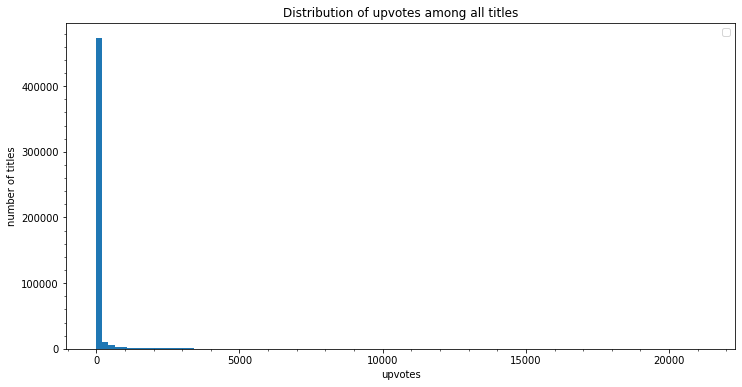

In [36]:
n_bins = 100
fig = plt.figure(figsize=(12, 6))
axs = fig.add_subplot(1, 1, 1)
axs.legend()
axs.set(
    xlabel=r'upvotes',
    ylabel=r'number of titles',
    title="Distribution of upvotes among all titles",
)
axs.minorticks_on()
axs.hist(
    upvotes_list,
    bins=n_bins,
    label=''
)
plt.show()

No handles with labels found to put in legend.


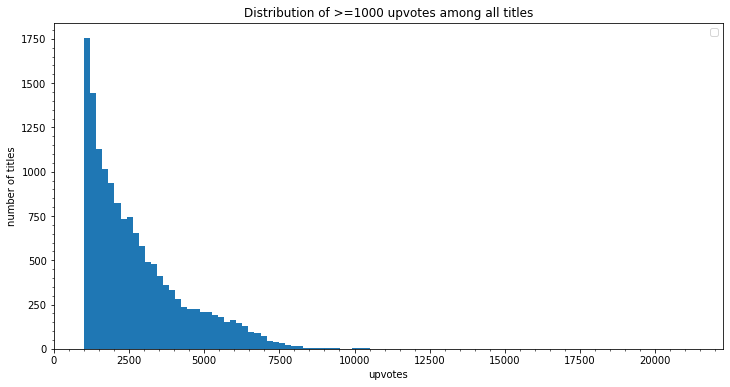

In [37]:
'''
The above graph shows that most of the titles have obtained upvotes <1000. So we remove
such upvotes and then replot the graph to see the distribution in the other region.
'''
upvotes_list_trimmed_1000 = [upvotes for upvotes in upvotes_list if upvotes >= 1000]

fig = plt.figure(figsize=(12, 6))
axs = fig.add_subplot(1, 1, 1)
axs.legend()
axs.set(
    xlabel=r'upvotes',
    ylabel=r'number of titles',
    title="Distribution of >=1000 upvotes among all titles",
)
axs.minorticks_on()
axs.hist(
    upvotes_list_trimmed_1000,
    bins=n_bins,
    label=''
)
plt.show()

No handles with labels found to put in legend.


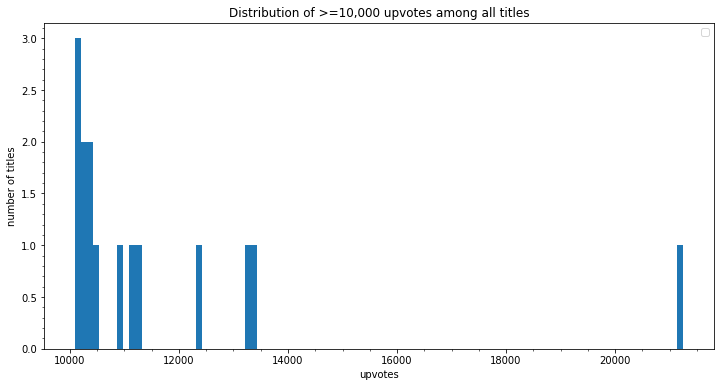

In [38]:
'''
The above graph shows that most of the titles have obtained upvotes <1000. So we remove
such upvotes and then replot the graph to see the distribution in the other region.
'''
upvotes_list_trimmed_10000 = [upvotes for upvotes in upvotes_list_trimmed_1000 if upvotes >= 10000]

fig = plt.figure(figsize=(12, 6))
axs = fig.add_subplot(1, 1, 1)
axs.legend()
axs.set(
    xlabel=r'upvotes',
    ylabel=r'number of titles',
    title="Distribution of >=10,000 upvotes among all titles",
)
axs.minorticks_on()
axs.hist(
    upvotes_list_trimmed_10000,
    bins=n_bins,
    label=''
)
plt.show()

## Analysing over_18 data column

Conclusions from this analysis are:
1. Only a handful (320) of news articles are marked as over_18. They form just over 0.06% of the entire dataset.
1. We find authors with the most number of over18 articles.

In [39]:
'''
Statistics around over_18 column.
'''
over_18_count = {True: 0, False: 0}
# A dict that saves the author as key and number of over_18 titles as value.
author_count_over_18 = {}

for chunk in pd.read_csv(filename, sep=',', header=0, chunksize=100_000):
    for over_18, author in zip(chunk['over_18'], chunk['author']):
        over_18_count[over_18] += 1
        if over_18:
            author_count_over_18[author] = author_count_over_18.get(author, 0) + 1

print('Over 18 stats:', over_18_count)
author_count_over_18_list = list(author_count_over_18.items())
author_count_over_18_list.sort(key=lambda a:a[1], reverse=True)

print('\nAuthors with most over18 articles are:')
for author, count in author_count_over_18_list[:10]:
    print('  {}, count={}'.format(author, count))

Over 18 stats: {True: 320, False: 508916}

Authors with most over18 articles are:
  readerseven, count=6
  ScotiaTide, count=4
  SyrianGuy, count=4
  Rocker13666, count=4
  downtown14, count=3
  uptodatepronto, count=3
  misterAction, count=3
  orangeflower2015, count=3
  alllie, count=2
  stesch, count=2


## Document Clustering using K-Means

The over18 articles are limited and a good candidate for clustering. We use k-means clustering to identify different types of over18 articles. For each cluster we then print some top documents to manully name/identify the cluster.

In [40]:
'''
Since number of over18 articles are less, we can try clustering those titles and
see if we can find categories of titles that are over18.
'''
over_18_corpus = []
for chunk in pd.read_csv(filename, sep=',', header=0, chunksize=100_000):
    for over_18, title in zip(chunk['over_18'], chunk['title']):
        if over_18:
            title = re.sub(r'[^\w ]', ' ', title)
            over_18_corpus.append(title)

print(len(over_18_corpus))

320


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Since number of examples are less (320) we use less features (50).
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=50)
X = vectorizer.fit_transform(over_18_corpus)
print(vectorizer.get_feature_names())
print(len(vectorizer.get_feature_names()))
print(X.shape)

['activists', 'al', 'attack', 'bahrain', 'bodies', 'child', 'chinese', 'dead', 'death', 'femen', 'footage', 'forces', 'found', 'graphic', 'group', 'head', 'images', 'isis', 'killed', 'man', 'naked', 'new', 'nsfl', 'nsfw', 'old', 'paris', 'people', 'photo', 'photos', 'pics', 'pictures', 'police', 'protest', 'protester', 'protesters', 'sex', 'shot', 'shows', 'soldiers', 'syria', 'syrian', 'topless', 'ukraine', 'victims', 'video', 'warning', 'woman', 'women', 'world', 'year']
50
(320, 50)


In [42]:
# We use mini-batch k-means which is useful if the entire training data cannot be loaded at once.
from sklearn.cluster import MiniBatchKMeans

### Cluster similarity metrics

To quantify the quality of the cluster formed, we use intra cluster distance metric. Our target should be to have minimum intra cluster distance. But note that an arbitrarily high number of clusters will always give low intra cluster distance. It has two variants:

1. Average distance between any two points in a cluster.
$$Score_C = \frac{1}{\vert C\vert \vert 1-C\vert} \sum_{x, y \in C, x \neq y} distance(x, y)$$
$$Score = \frac{1}{K} \sum_{C \in \Omega} Score_C$$
where,

$x, y$ are data points in the cluster $C$

$\vert C\vert$ is the size of cluster

$distance(x, y)$ is the euclidean distance between points $x$ and $y$

$\Omega$ is the set of all clusters and has size $K$.

2. Average distance between a point and centroid in a cluster.

$$Score_C = \frac{1}{\vert C\vert}\sum_{x\in C}distance(x, centroid(C))$$
$$Score = \frac{1}{K} \sum_{C \in \Omega} Score_C$$

where,

$centroid(C)$ is the centroid vector of cluster $C$.

Another metric could be to use inter-cluster similarity/distance metric where we compare two different clusters with each other. There the target should be to have maximum average inter-cluster distance. We don't this metric in our analysis.

In [43]:
'''
Input:
    X - numpy 2D float matrix representation of data where each row is a title/sentence.
    labels (list)- labels of each input data as formed by kmeans algorithm.
    num_clusters - the number of clusters used while running k-means.
Returns:
    A numpy list where ith index represents the intra-cluster distance of the ith cluster.
    Size of list is equal to num_clusters. 
'''
def intra_cluster_distance(X, labels, num_clusters):
    dist_score = np.zeros(num_clusters)
    k_to_tid_list = {}
    for i in range(num_clusters):
        k_to_tid_list[i] = []
    for tid, label in enumerate(labels):
        k_to_tid_list[label].append(tid)
    # print(k_to_tid_list)

    for cid, tid_list in k_to_tid_list.items():
        sum_dist = 0
        for i in range(len(tid_list)):
            for j in range(i+1, len(tid_list)):
                xi = X[tid_list[i], :]
                xj = X[tid_list[j], :]
                sum_dist += np.square(scipy.sparse.linalg.norm(xi - xj))
        sum_dist *= 2 # because (i, j) and (j, i) distances are equal
        dist_score[cid] = 1/(len(tid_list) * (len(tid_list) - 1)) * sum_dist if len(tid_list) > 1 else 0
    
    return dist_score

In [44]:
def load_list(filename):
    pickle_off = open (filename, "rb")
    myList = pickle.load(pickle_off)
    return myList

def save_list(filename, myList):
    with open(filename, 'wb') as fh:
        pickle.dump(myList, fh)

In [45]:
'''
Find optimal number of clusters based on intra cluster distance b/w points. This method
is very slow because of quadratic number of comparisons in every cluster.
'''

# A list of tuple (num_clusters, avg_score)
avg_intra_cluster_scores = []

avg_ics_filename = 'avg_intra_cluster_scores.txt'
if os.path.isfile('avg_intra_cluster_scores.txt'):
    avg_intra_cluster_scores = load_list(avg_ics_filename)
else:
    print('Pickled file not found. Will create again.')
    for num_clusters in range(2, 30):
        kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size=100, max_iter=10)
        kmeans = kmeans.fit(X)

        dist_score = intra_cluster_distance(X, kmeans.labels_, num_clusters)
        avg_intra_cluster_scores.append((num_clusters, np.average(dist_score)))
    save_list(avg_ics_filename, avg_intra_cluster_scores)

### How to choose k?

We plot a graph between number of clusters and intra-cluster distance and pick the k where the graph forms an `elbow`. Such an elbow curve may not be always visible clearly.

No handles with labels found to put in legend.


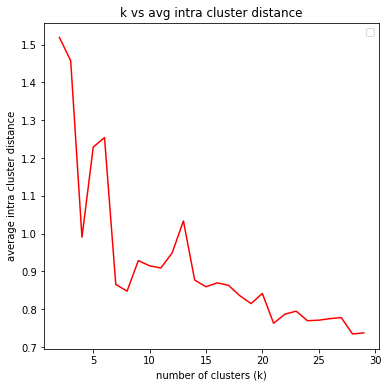

In [46]:
fig = plt.figure(figsize=(6, 6))
axs = fig.add_subplot(1, 1, 1)
axs.plot(
    [num_clusters for num_clusters, score in avg_intra_cluster_scores],
    [score for num_clusters, score in avg_intra_cluster_scores],
    color='red',
    label=''
)
axs.legend()
axs.set(
    xlabel=r'number of clusters (k)',
    ylabel=r'average intra cluster distance',
    title='k vs avg intra cluster distance',
)
plt.show()

In [47]:
'''
Another distance metric for intra cluster distance is to use distance from cluster
centre.
'''
def intra_cluster_distance_from_centroid(X, labels, num_clusters, cluster_centers):
    dist_score = np.zeros(num_clusters)
    k_to_tid_list = {}
    for i in range(num_clusters):
        k_to_tid_list[i] = []
    for tid, label in enumerate(labels):
        k_to_tid_list[label].append(tid)
    
    for cid, tid_list in k_to_tid_list.items():
        sum_dist = 0
        for tid in tid_list:
            x = X[tid, :]
            sum_dist += np.square(np.linalg.norm(x - cluster_centers[cid]))
        dist_score[cid] = sum_dist

    return dist_score

In [48]:
'''
Find optimal number of clusters based on intra cluster distance from centroid.
This method will be faster than the previous one due to linear number of computations
in every cluster.
'''

# A list of tuple (num_clusters, avg_score)
avg_intra_cluster_scores_centroid = []

for num_clusters in range(2, 30):
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size=100, max_iter=10)
    kmeans = kmeans.fit(X)

    dist_score = intra_cluster_distance_from_centroid(X, kmeans.labels_, num_clusters, kmeans.cluster_centers_)
    avg_intra_cluster_scores_centroid.append((num_clusters, np.average(dist_score)))

No handles with labels found to put in legend.


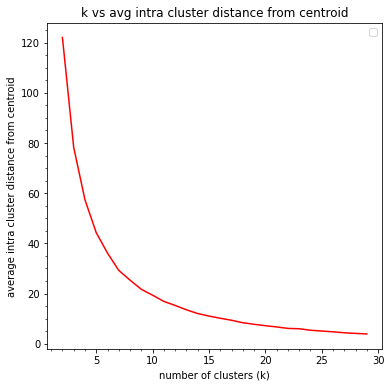

In [49]:
fig = plt.figure(figsize=(6, 6))
axs = fig.add_subplot(1, 1, 1)
axs.plot(
    [num_clusters for num_clusters, score in avg_intra_cluster_scores_centroid],
    [score for num_clusters, score in avg_intra_cluster_scores_centroid],
    color='red',
    label=''
)
axs.legend()
axs.minorticks_on()
axs.set(
    xlabel=r'number of clusters (k)',
    ylabel=r'average intra cluster distance from centroid',
    title='k vs avg intra cluster distance from centroid',
)
plt.show()

### Printing Clusters

From the above 2 graphs, we see that calculating distances from centroid gives a better curve (in less time). We can choose 6-8 as the optimal number of clusters.

To print every cluster, we print top k (3 or 5) titles from every cluster that are the closest to the cluster centre.

From the observed clusters, it is rather difficult to name the cluster into a well-defined category. We might have to look into more examples (>10).

In [50]:
def print_centroid_titles(X, labels, num_clusters, cluster_centers, corpus, titles_per_c):
    cid_to_tid_dist_list = {}
    for cid in range(num_clusters):
        cid_to_tid_dist_list[cid] = []

    for tid, cid in enumerate(labels):
        dist = np.linalg.norm(cluster_centers[cid] - X[tid, :])
        cid_to_tid_dist_list[cid].append((tid, dist))
    
    for cid, tid_dist_list in cid_to_tid_dist_list.items():
        print('Cluster no. {}'.format(cid))
        tid_dist_list.sort(key=lambda a:a[1])
        for i, tid_dist in enumerate(tid_dist_list[:titles_per_c]):
            print('  {} -> {}'.format(i+1, corpus[tid_dist[0]]))
        print()

In [51]:
'''
When using intra-cluster distance from centroid, we a get curve where we can see
elbow at around 5. So we can take num_clusters as 5.

Now we will print titles_per_c titles from each cluster.
'''

optimal_num_clusters = 5
titles_per_c = 5
kmeans = MiniBatchKMeans(n_clusters=optimal_num_clusters, random_state=0, batch_size=100, max_iter=10)
kmeans = kmeans.fit(X)
print_centroid_titles(X, kmeans.labels_, optimal_num_clusters, kmeans.cluster_centers_, over_18_corpus, titles_per_c)

Cluster no. 0
  1 -> BBC News   Phone hacking  Brooks steps down over phone hacking
  2 -> Five Moroccan self immolations 
  3 -> Special Report  Brazil s gringo problem  its borders 
  4 -> Slovakian prime minister says his public s patience with European rescue measures has run out
  5 -> Mans penis stolen by thieves in China

Cluster no. 1
  1 -> Tabloid Horrifies Germany  Poland s Yellow Press Turns Blood Red  if you follow the link to the gallery  4th picture is NSFW in the US 
  2 -> Love Parade Dortmund  Techno Festival Breaks Record with 1 6 Million  with a 90x90 px NSFW thumbnail 
  3 -> IDF kills young Palestinian boy  Potentially NSFW 
  4 -> Eye Opening Montage about the Gaza Massacre  NSFW 
  5 -> NSFW  Taliban Barbers Frequently Sever Customer s Heads 

Cluster no. 2
  1 -> Journalism Face Off  Russian Shadiness vs  American  Objectivity    Interesting Look at the Underbelly of Journalism  incl NSFW video 
  2 -> Google didn t comply with Argentina s request to remove NSF

## Classification Model for over-18 titles

### Using (Glove) Word Embeddings

In the previous section, we created word representation from the given dataset. But this is not possible if the dataset is online. It is better to use an already trained word representation. We use GloVe embeddings which are pre-trained word vectors on a very large dataset.

We use 100 length embedding given the size of our model.

In [103]:
%%shell

# Download Glove embeddings if they do not already exist.
FILE='glove.6B.zip'
if test -f "$FILE"; then
    echo "$FILE already exists."
else
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip glove.6B.zip
fi

glove.6B.zip already exists.


In [104]:
'''
Class to create Glove embeddings for a given sentence. Each word of a sentence is
converted to a fixed length vector. The vector representation of a sentence is the 
element wise mean of the vectors of each individual word in that sentence.
Input:
    embedding_size (int): determines the embedding size of the sentence. It can take
        value from [50, 100, 200, 3000].
'''
class GloveVectorizer:
    def __init__(self, embedding_size):
        if embedding_size not in [50, 100, 200, 300]:
            raise Exception('{} embedding_size is not allowed.'.format(embedding_size))
        
        # load in pre-trained word vectors
        print('Loading word vectors...')
        word2vec = {}
        embedding = []
        idx2word = []
        filename = 'glove.6B.' + str(embedding_size) + 'd.txt'
        with open(filename) as f:
            # is just a space-separated text file in the format:
            # word vec[0] vec[1] vec[2] ...
            for line in f:
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
                embedding.append(vec)
                idx2word.append(word)
        print('Found %s word vectors.' % len(word2vec))

        # save for later
        self.word2vec = word2vec
        self.embedding = np.array(embedding)
        self.word2idx = {v: k for k, v in enumerate(idx2word)}
        self.V, self.D = self.embedding.shape

    def fit(self, data):
        pass

    def transform(self, data):
        X = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0
        for sentence in data:
            tokens = sentence.lower().split()
            vecs = []
            for word in tokens:
                if word in self.word2vec:
                    vec = self.word2vec[word]
                    vecs.append(vec)
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n += 1
        print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
        return X

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [105]:
vectorizer = GloveVectorizer(embedding_size=100)

Loading word vectors...
Found 400000 word vectors.


In [106]:
# Check how many woords from our vocabulary are present in the glove embeddings
print('Unique words from dataset: {}'.format(len(all_unique_words)))
glove_words = set(vectorizer.word2vec.keys())
dataset_and_glove = all_unique_words.intersection(glove_words)
print('Dataset words present in Glove embeddings: {}'.format(len(dataset_and_glove)))

Unique words from dataset: 87835
Dataset words present in Glove embeddings: 71041


In [120]:
# To see what sort of words are part of the dataset but not present in glove embeddings.
not_in_glove = all_unique_words - glove_words
print(list(not_in_glove)[:20])

'''
Words that are not present in the glove embeddings fall into one of the below categories:
1. misspelt words
2. foreign language words
3. digits
4. concatenation of two words
5. unofficial words
6. other reasons.

We will use zero array embeddings [0, 0, ... , 0] for such words.
'''

['searnings', 'польша', 'kony2012', 'cybe', 'ribeauville', '110deg', 'crowdmap', 'dyngjujökull', 'galantgate', 'daif', 'xiaobos', '08bdaho', 'holande', 'toet', 'daraprim', 'diaf', 'tricorders', 'verdians', 'marsé', 'araab']


'\nWords that are not present in the glove embeddings fall into one of the below categories:\n1. misspelt words\n2. foreign language words\n3. digits\n4. concatenation of two words\n5. unofficial words\n6. other reasons.\n\nWe will use zero array embeddings [0, 0, ... , 0] for such words.\n'

In [108]:
# Check the embedding for a word.
print(vectorizer.word2vec['happy'])

[-0.090436   0.19636    0.29474   -0.47706   -0.80436    0.3078
 -0.55205    0.58453   -0.17056   -0.84846    0.19528    0.23671
  0.46827   -0.58977   -0.12163   -0.24697   -0.072944   0.17259
 -0.0485     0.9527     0.50629    0.58497   -0.19367   -0.45459
 -0.031095   0.51633   -0.24052   -0.1007     0.53627    0.024225
 -0.50162    0.73692    0.49468   -0.34744    0.89337    0.057439
 -0.19127    0.39333    0.21182   -0.89837    0.078704  -0.16344
  0.45261   -0.41096   -0.19499   -0.13489   -0.016313  -0.021849
  0.17136   -1.2413     0.079503  -0.91144    0.35699    0.36289
 -0.24934   -2.1196     0.14534    0.52964    0.90134    0.033603
  0.022809   0.70625   -1.0362    -0.59809    0.70592   -0.072793
  0.67033    0.52763   -0.47807   -0.67374    0.36632   -0.38284
 -0.10349   -0.6402     0.18104    0.82568    0.066403  -0.40791
 -0.083813  -0.36487    0.045362  -0.073527  -0.20117    0.37441
 -1.4024    -0.25605   -0.4708    -0.16145   -0.87921   -0.36325
 -0.17357   -0.077983

### Create data and Test-Train split

For our classifier we need to create training and testing data. We see that the entire dataset has only 320 positive (over18) examples. We can tolerate some class imbalance but not too much. We tried with multiple sizes of negative examples and noticed that 1000-2000 examples work well. So, we shall use 1500 random negative examples from the dataset to create test+train dataset.

After that we will shuffle the data, use 80:20 split for train:test data and train our model. We use K-fold cross validation on the train data to select the best model hyperparameters.

In [109]:
# Create train, validation and test data.
# Over 18 data is present in over_18_corpus.

# The number of non-over-18 examples to use from the dataset.
not_over_18_size = 2000 # 2880
not_over_18_corpus = []
not_over_18_y = np.zeros(not_over_18_size)

# from the first 100_000 titles, choose `not_over_18_size` non-over-18 examples.
for chunk in pd.read_csv(filename, sep=',', header=0, chunksize=100_000):
    indices = np.random.choice(100000, not_over_18_size + 500)
    # print(indices)
    for over_18, title in zip(chunk['over_18'][indices], chunk['title'][indices]):
        if not over_18:
            title = re.sub(r'[^\w ]', ' ', title)
            not_over_18_corpus.append(title)
    break
not_over_18_corpus = not_over_18_corpus[:not_over_18_size]

In [110]:
print(len(not_over_18_corpus))
print(not_over_18_corpus[0:3])
print(len(over_18_corpus))
over_18_y = np.ones(320)

2000
['New Series documenting the revolution tearing through the Arab world ', 'Can you be a volunteer and teach in Haiti  If not can you help by  telling your friends', 'Comedian Jón Gnarr is the newly elected mayor of Reykjavík  the capital city of Iceland ']
320


In [111]:
# Create the combined data
X_combined = over_18_corpus + not_over_18_corpus
Y_combined = np.append(over_18_y, not_over_18_y)
print(len(X_combined), Y_combined.shape)
assert not_over_18_size + 320 == len(X_combined)
assert not_over_18_size + 320 == Y_combined.shape[0]

# Print some examples
print(X_combined[:3])
print(X_combined[-3:])

2320 (2320,)
['Pics from the Tibetan protests   more graphic than Wikileaks  nsfw  graphic ', 'MI5 linked to Max Mosley s Nazi style  sadomasochistic sex orgy  Mosley s father led the British Union of Fascists in the 30s and 40s  His mother was a great admirer of Adolf Hitler  NSFW ', 'Tabloid Horrifies Germany  Poland s Yellow Press Turns Blood Red  if you follow the link to the gallery  4th picture is NSFW in the US ']
['The Indian state of Kerala is famous as the land of coconuts  But climbing trees has been the only way to pick them  Until now   ', 'Swine flu spread over time  Map ', 'Australia  Wildfire Death Toll Rises To 200  Police']


In [112]:
X_matrix = vectorizer.transform(X_combined)
Y_matrix = np.array(Y_combined)
print(X_matrix.shape, Y_matrix.shape)

Numer of samples with no words found: 2 / 2320
(2320, 100) (2320,)


### Pipeline training and evaluation

We use pipeline construct to make training and testing easier. Input data is normalized to have mean 0 and variance 1. We use support vector classifier as it performs well on low data regimes and is known to have good performance for classification tasks. We tried various kernels and rbf kernel performs much better than others. Hyperparameters to tune are gamma and C. We use Grid search to find the best values.

We use F1 score to select the best hyperparameter rather than accuracy because the data is imbalanced.

*Handling very large data:*

In this example we sample the input to pick only ~2000 examples to train the model. This is because of very less (320) positive examples. If the ratio of positive and negative examples was better, we could have used more data to train the classifier. In that case, it would be better to use online training models like SGDClassifier which allows partial training over a chunk of training data.

In [113]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_matrix, Y_matrix, random_state=0,
                                                    train_size=0.80)

# to normalize the data.
scalar = StandardScaler()

# our binary classifier with class weights because data is not balanced.
svc = SVC(class_weight='balanced', kernel='rbf') 

# To find the best parameter using grid search. We use F1 score as the scoring metric
# because of unbalanced classes. Optimizing on accuracy is not correct here.
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}
grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='f1')

pipe = Pipeline([('scaler', scalar), ('grid_search_svc', grid_search_svc)])

# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('grid_search_svc',
                 GridSearchCV(cv=None, error_score=nan,
                              estimator=SVC(C=1.0, break_ties=False,
                                            cache_size=200,
                                            class_weight='balanced', coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False),
                              iid='deprecated', n_jobs=None,
                              param_grid={'C': [0.1, 1, 10, 100],
                   

In [114]:
print(pipe.named_steps.grid_search_svc.best_params_)
print(pipe.named_steps.grid_search_svc.best_estimator_)

{'C': 1, 'gamma': 0.01}
SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [115]:
from sklearn.metrics import f1_score

y_test_pred = pipe.predict(X_test)
print('Mean average accuracy:', np.mean(y_test_pred == y_test))
print('F1 score:', f1_score(y_true=y_test, y_pred=y_test_pred), pipe.score(X_test, y_test))

Mean average accuracy: 0.8728448275862069
F1 score: 0.556390977443609 0.556390977443609


In [116]:
'''
For a given title array having multiple titles, tell if they are over_18 or not.
Input:
    title_array = A list of strings where each string is s title. Length of array is n.
Returns:
    over_18_array (ndarray): Array of shape (n,). Value 1 indicates over_18 title
        and 0 indicates not over_18 title.
'''
def predict_title_class(title_array):
    title_x = vectorizer.transform(title_array)
    title_y = pipe.predict(title_x)
    return title_y

In [117]:
# Use the classifier to predict some random example sentences. These examples are not
# part of the dataset.
predict_title_class(["the usa bombed on someone. what to in crisis? ",
                     "the baseball match was a fun event",
                     "The woman was found playing in her room.",
                     "The man was found dead, shot in the head, and naked.",
                     "sex and the city",
                     "The man was found with child porn and his penis was cut",
                     "Machine learning is the new electricity and has huge potential."])

Numer of samples with no words found: 0 / 7


array([0., 1., 0., 1., 0., 1., 0.])

In [118]:
'''
We picked the training and testing data from the first 100,000 examples. So we use the 
next 100,000 examples to see the model's performance on them. We precison, recall, F1 scores
for 0 (not over18) and 1 (over18) labels.

Analysis:
The F1 score for label=1 is very low (<0.02). This is because the input data is highly 
skewed. label_1:label_0 = 75:99925. But the recall on label=1 is high (~0.88) which 
indicates that an over_18 title is mostly identified correctly.
'''

from sklearn.metrics import precision_recall_fscore_support

# Let's see how our model performs against unseen data.
for chunk_no, chunk in enumerate(pd.read_csv(filename, sep=',', header=0, chunksize=100_000)):
    # Since we picked train-test data from chunk 0, we use other chunks to test performance.
    if chunk_no > 0:
        y_test = []
        x_test = []
        for over_18, title in zip(chunk['over_18'], chunk['title']):
            y_test.append(1 if over_18 else 0)
            x_test.append(re.sub(r'[^\w ]', ' ', title))
        y_test_pred = predict_title_class(x_test)
        # print(y_test)
        # print(y_test_pred)
        precision, recall, f1score, support = precision_recall_fscore_support(
            y_true=y_test, y_pred=y_test_pred, average=None
        )
        print('precion={}, recall={}, F1={}, support={}'.format(
            precision, recall, f1score, support
        ))
        # Just see performance for 100,000 examples.
        break

Numer of samples with no words found: 10 / 100000
precion=[0.99995541 0.00689655], recall=[0.89768326 0.94666667], F1=[0.94606339 0.01369335], support=[99925    75]
